# EDA for energy anomaly detection data
Data sourced from Kaggle competition: https://www.kaggle.com/competitions/energy-anomaly-detection

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import svm, preprocessing
from sklearn.impute import SimpleImputer
from sklearn import metrics
from category_encoders.target_encoder import TargetEncoder

In [6]:
df_train = pd.read_csv("../DATA/energy-anomaly-detection/train.csv")
df_weather = pd.read_csv("../DATA/energy-anomaly-detection/weather_train.csv")
df_building = pd.read_csv("../DATA/energy-anomaly-detection/building_metadata.csv")

In [30]:
print(df_building['primary_use'].unique())

<StringArray>
[                    'Education',           'Lodging/residential',
                        'Office', 'Entertainment/public assembly',
                         'Other',                        'Retail',
                       'Parking',               'Public services',
             'Warehouse/storage',        'Food sales and service',
             'Religious worship',                    'Healthcare',
                       'Utility',            'Technology/science',
      'Manufacturing/industrial',                      'Services']
Length: 16, dtype: str


## Stats

In [7]:
# This is more verbose and generally less common than merge
df_all = df_train.set_index(['building_id']).join(
    df_building.set_index(['building_id']), 
    how='left'
).reset_index()

df_all = df_all.set_index(['site_id', 'timestamp']).join(
    df_weather.set_index(['site_id', 'timestamp']), 
    how='left'
).reset_index()

te = TargetEncoder()
df_all['primary_use_enc'] = te.fit_transform(df_all['primary_use'], df_all['anomaly'])


### Correlation

Site_id will be retained, but floor_count will be dropped as they are highly correlated, but a lot of data is missing for the latter.
Site_id will be dropped and just building_id will be retained, just to help the model udnerstand the context of the buildings.
Primary use will be dropped as anomalies are equally distributed accross all categories.

In [ ]:
# Calculate the full correlation matrix
pearson_corr = df_all.select_dtypes(include=['int64', 'float64']).corr(method='spearman')

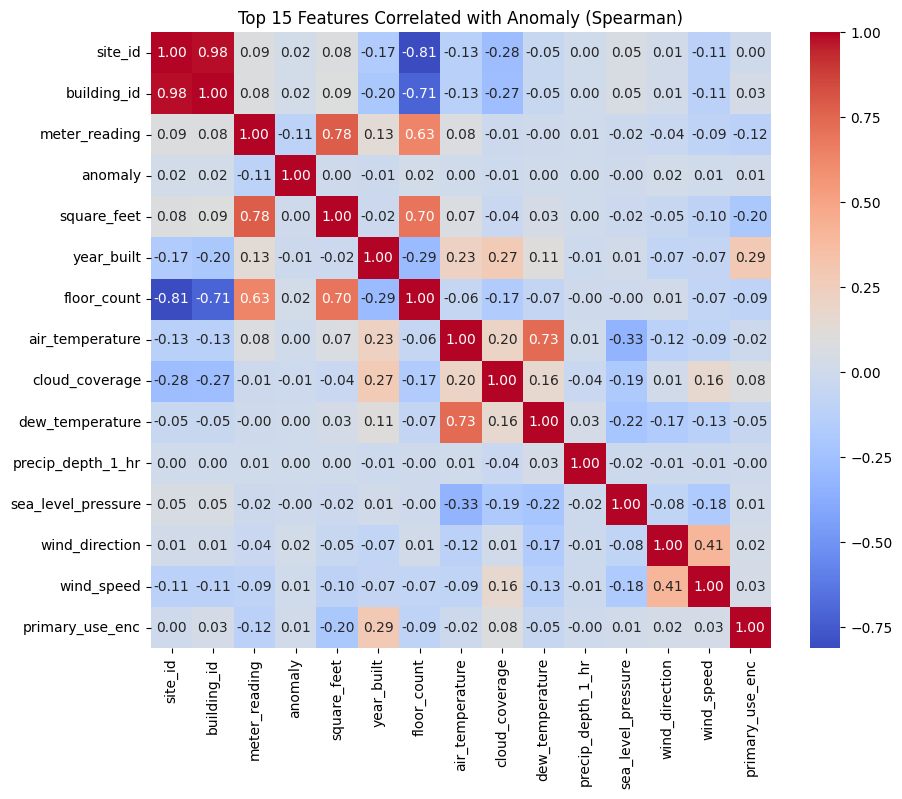

In [34]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 15 Features Correlated with Anomaly (Spearman)")
plt.show()

In [35]:
# See the actual percentages
analysis = df_all.groupby('primary_use')['anomaly'].mean().sort_values(ascending=False)
print(analysis)

primary_use
Other                            0.036973
Office                           0.022721
Lodging/residential              0.022683
Entertainment/public assembly    0.021468
Public services                  0.021347
Religious worship                0.020613
Education                        0.020507
Food sales and service           0.019809
Healthcare                       0.018580
Parking                          0.018272
Manufacturing/industrial         0.017133
Services                         0.011822
Name: anomaly, dtype: float64


In [42]:
# See the actual percentages
analysis = df_all.groupby('dew_temperature')['anomaly'].mean().sort_values(ascending=False)
print(analysis)

dew_temperature
 22.9    1.000000
 22.1    1.000000
 21.5    0.666667
 21.4    0.500000
 21.9    0.333333
           ...   
 19.3    0.000000
 19.2    0.000000
 19.1    0.000000
-32.7    0.000000
-32.9    0.000000
Name: anomaly, Length: 522, dtype: float64


### Perason correlation

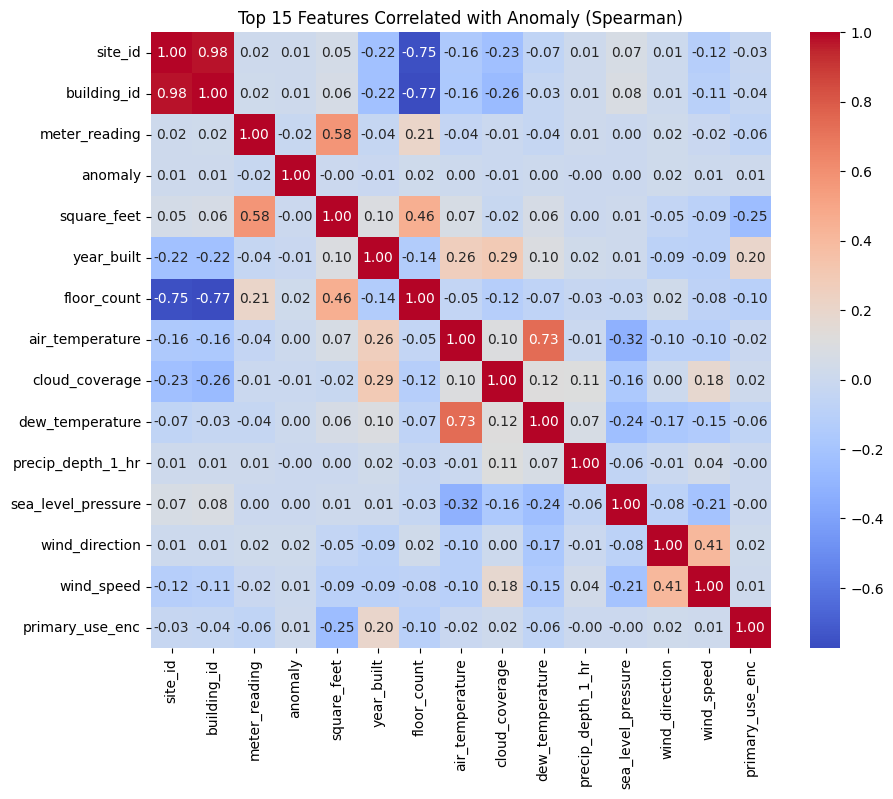

In [ ]:
pearson_corr = df_all.select_dtypes(include=['int64', 'float64']).corr(method='pearson')
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 15 Features Correlated with Anomaly (pearson)")
plt.show()

### Mutual Information (independence)

In [2]:
input_path = "../data/energy-anomaly-detection/"
df_all = pd.read_csv(input_path + "train_features.csv")

In [8]:
# 1. Prepare your features and target
X = df_all.drop(columns=['anomaly', 'timestamp']).copy()
y = df_all['anomaly']

# 2. Handle missing values (NaNs)
# Strategy: Use Median for numeric and 'Missing' for categories
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna('Unknown')

# 3. Handle the categorical strings (as we did before)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = le.fit_transform(X[col].astype(str))

# 4. Identify discrete feature indices
discrete_features = [X.columns.get_loc(col) for col in X.columns 
                     if col in df_all.select_dtypes(include=['object', 'category']).columns 
                     or col == 'site_id']

# 5. Run MI (using a sample for speed)
from sklearn.feature_selection import mutual_info_classif
X_sample = X.sample(n=100000, random_state=42)
y_sample = y.loc[X_sample.index]

mi_scores = mutual_info_classif(X_sample, y_sample, discrete_features=discrete_features)

C:\Users\ferna\AppData\Local\Temp\ipykernel_27180\366998386.py:16: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in X.select_dtypes(include=['object', 'category']).columns:
C:\Users\ferna\AppData\Local\Temp\ipykernel_27180\366998386.py:21: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/doc

C:\Users\ferna\AppData\Local\Temp\ipykernel_27180\3565420784.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


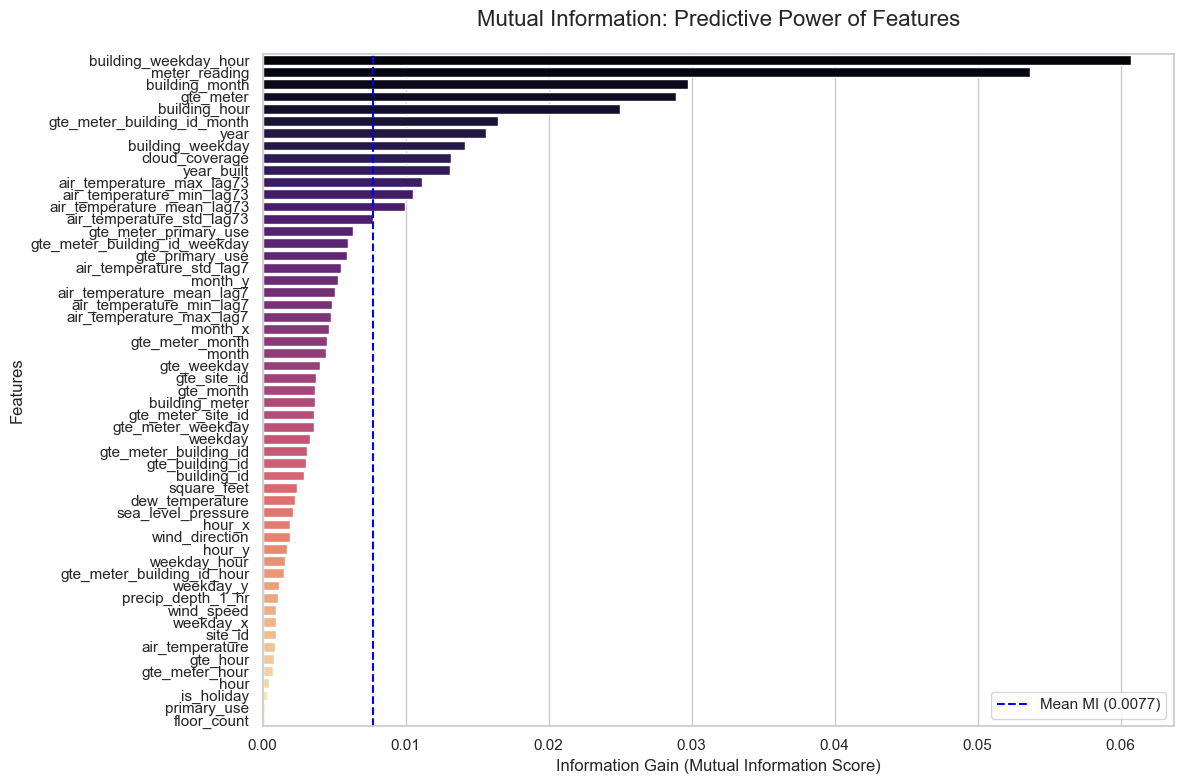

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create the results DataFrame (assuming mi_scores was already calculated)
mi_summary = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

# 2. Plotting
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the bar plot
ax = sns.barplot(
    x='MI Score', 
    y='Feature', 
    data=mi_summary, 
    palette='magma'
)

# 3. Add a Mean Threshold Line
# Features below this line often provide very little "information gain"
mi_mean = mi_summary['MI Score'].mean()
plt.axvline(mi_mean, color='blue', linestyle='--', label=f'Mean MI ({mi_mean:.4f})')

# 4. Final Touches
plt.title('Mutual Information: Predictive Power of Features', fontsize=16, pad=20)
plt.xlabel('Information Gain (Mutual Information Score)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

C:\Users\ferna\AppData\Local\Temp\ipykernel_27180\3565420784.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


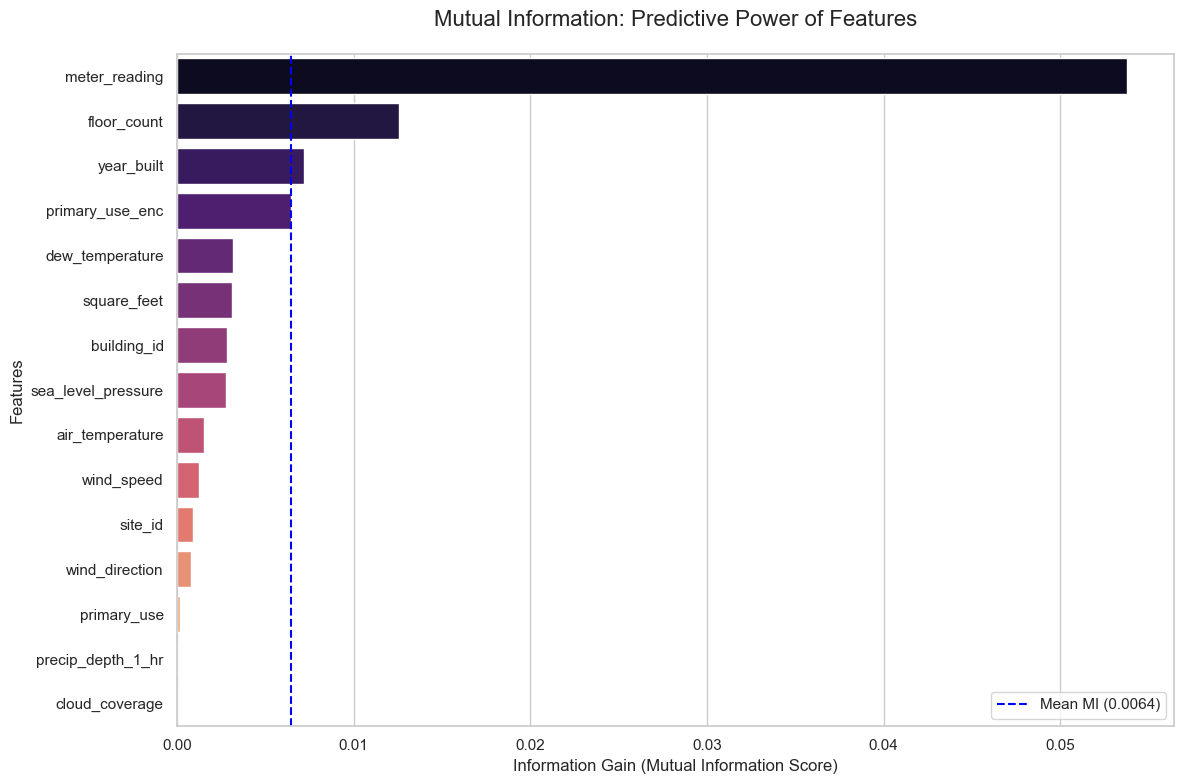

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create the results DataFrame (assuming mi_scores was already calculated)
mi_summary = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

# 2. Plotting
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the bar plot
ax = sns.barplot(
    x='MI Score', 
    y='Feature', 
    data=mi_summary, 
    palette='magma'
)

# 3. Add a Mean Threshold Line
# Features below this line often provide very little "information gain"
mi_mean = mi_summary['MI Score'].mean()
plt.axvline(mi_mean, color='blue', linestyle='--', label=f'Mean MI ({mi_mean:.4f})')

# 4. Final Touches
plt.title('Mutual Information: Predictive Power of Features', fontsize=16, pad=20)
plt.xlabel('Information Gain (Mutual Information Score)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()